# End-to-End Example #1

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Data ingestion](#Data-ingestion)
  3. [Data inspection](#Data-inspection)
  4. [Data conversion](#Data-conversion)
3. [Training the Tensorflow model](#Training-the-Tensorflow-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
5. [Validate the model for use](#Validate-the-model-for-use)


## Introduction

Welcome to our first end-to-end example! Today, we're working through a classification problem, specifically of images of handwritten digits, from zero to nine. Let's imagine that this dataset doesn't have labels, so we don't know for sure what the true answer is. In later examples, we'll show the value of "ground truth", as it's commonly known.

Today, however, we need to get these digits classified without ground truth. A common method for doing this is a set of methods known as "clustering", and in particular, the method that we'll look at today is called Tensorflow clustering.  A TensorFlow "cluster" is a set of "tasks" that participate in the distributed execution of a TensorFlow graph. Each task is associated with a TensorFlow "server", which contains a "master" that can be used to create sessions, and a "worker" that executes operations in the graph.

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are two parts to this:

1. The role(s) used to give learning and hosting access to your data. Here we extract the role you created earlier for accessing your notebook.  See the documentation if you want to specify  a different role
1. The S3 bucket name and locations that you want to use for training and model data.

In [9]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket='<emmayu>'

### Data ingestion

Next, we read the dataset from the existing repository into memory, for preprocessing prior to training.  In this case we'll use the MNIST dataset, which contains 70K 28 x 28 pixel images of handwritten digits.  For more details, please see [here](http://yann.lecun.com/exdb/mnist/).

This processing could be done *in situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.

In [10]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 948 ms, sys: 244 ms, total: 1.19 s
Wall time: 9.37 s


### Data inspection

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed. You can perform those tasks right here in the notebook. As an example, let's go ahead and look at one of the digits that is part of the dataset.

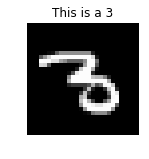

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

## Training the Tensorflow

Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn't meant to show off the performance of the k-means training algorithm.  
After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between 7 and 11 minutes.

In [8]:
!pip install tensorflow

    100% |████████████████████████████████| 45.9MB 26kB/s  eta 0:00:01    37% |████████████                    | 17.2MB 34.8MB/s eta 0:00:01
    100% |████████████████████████████████| 7.5MB 180kB/s eta 0:00:01
    100% |████████████████████████████████| 81kB 10.8MB/s ta 0:00:01
    100% |████████████████████████████████| 3.1MB 452kB/s eta 0:00:01
    100% |████████████████████████████████| 890kB 1.5MB/s eta 0:00:01
    100% |████████████████████████████████| 81kB 11.1MB/s ta 0:00:01
  Running setup.py bdist_wheel for absl-py ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/3c/0f/0a/6c94612a8c26070755559045612ca3645fea91c11f2148363e
  Running setup.py bdist_wheel for termcolor ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/de/f7/bf/1bcac7bf30549e6a4957382e2ecab04c88e513117207067b03
  Running setup.py bdist_wheel for gast ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/8e/fa/d6/77dd17d18ea23fd7b860e02623d27c1be451521af40dd4a13e
  Runnin

In [20]:
from time import time              
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [21]:
start_time = time()
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [22]:
# define graph input 
# mnist image shape 28*28=784
# 0-9 digits have 10 classes

x = tf.placeholder(tf.float32, [None, 784])

#define output label
y_label = tf.placeholder(tf.float32, [None, 10])

# define weights
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

# define model -Softmax function

y_predict = tf.nn.softmax(tf.matmul(x, W) + b)

In [23]:
# Minimize error using cross entropy
cross_entropy  = tf.reduce_mean(-tf.reduce_sum( y_label * tf.log(y_predict), reduction_indices=1))

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cross_entropy)

In [24]:
# Initialize

init = tf.global_variables_initializer()
sess = tf.InteractiveSession() 
sess.run(init)

In [25]:
# train 1000 times
# Test model accuracy
# total time used in training and prediction

for _ in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    sess.run(optimizer, feed_dict={x: batch_xs, y_label: batch_ys})
correct_predict = tf.equal(tf.argmax(y_predict,1), tf.argmax(y_label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predict, dtype='float'))
print('Accuracy:',sess.run(accuracy, feed_dict={x: mnist.test.images, y_label: mnist.test.labels}))
print('Training and Modeling time：%.3f' %(time() - start_time)+'sec')
sess.close()

Accuracy: 0.9184
Training and Modeling time：48.699sec
